In [1]:
# coding: utf8

In [2]:
import math
import pandas as pd
import numpy  as np
import seaborn as sb
import matplotlib.pyplot as plt

In [3]:
from __future__ import division
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split

In [4]:
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
sb.set(style="white", color_codes=True)

## Load the Data

In [10]:
titanic = pd.read_csv("data/train.csv")

In [11]:
INIT_DF = pd.read_csv("data/train.csv")

In [12]:
INIT_DF.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


## Missing data ?! Data cleaning

In [13]:
print "All the Nan are here !"
titanic.isnull().sum()

All the Nan are here !


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Data cleaning: Fix Age 
*Solution* : replace Nan with the mean

**TOTRY** : Random Gaussien variable

**TOTRY** : Verify the result of skiping data point


In [14]:
titanic["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [15]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

g = np.random.normal(29.699118, 14.526497, 100000)
fake_age = np.random.normal(29, 14, 117) 

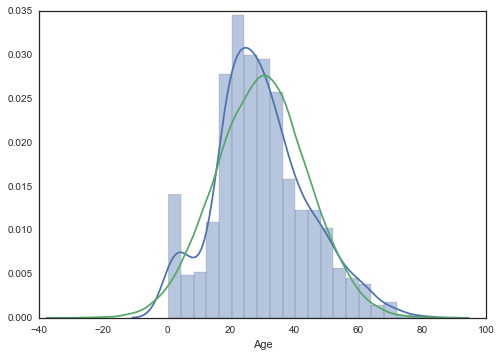

In [16]:
sb.distplot(titanic["Age"].dropna());
sb.kdeplot(g);

In [17]:
mean_age = titanic["Age"].mean()
print "The mean of the feature Age is : ",mean_age
print "All the Nan are replaced with %.2f"%math.ceil(mean_age)
titanic["Age"] = titanic["Age"].fillna(int(mean_age))

The mean of the feature Age is :  29.6991176471
All the Nan are replaced with 30.00


### Data cleaning: Fix the Cabin number
**TOTRY** : Binary vectors (ex: Embarked.C, Embarked.S, Embarked.Q)

In [18]:
titanic["Age"] = titanic["Age"].fillna(mean_age)
titanic["Cabin"] = titanic["Cabin"].fillna("unknow")
titanic["Cabin"] = map(lambda y: y[0].upper(), titanic["Cabin"])

In [19]:
bridges = sorted(titanic["Cabin"].unique())
print "All bridge: ",bridges
print "T is an Upper class room and U stand for Unknow"

All bridge:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U']
T is an Upper class room and U stand for Unknow


### Data cleaning: Embarked place

In [20]:
titanic["Embarked"] = titanic["Embarked"].fillna("C")

### Features Engineering

In [21]:
titanic["Sex"] = titanic["Sex"].map({'female': 0, 'male': 1}).astype(int) # femal = 0; male = 1

In [22]:
for place in ['C', 'Q', 'S']:
    titanic["Embarked.%s"%place] = map(lambda y: 1 if y == place else 0, titanic["Embarked"])

In [23]:
for pcl in ['1', '2', '3']:
    titanic["Pclass.%s"%pcl] = map(lambda y: 1 if y == int(pcl) else 0, titanic["Pclass"])

In [24]:
for bridge in bridges:
    titanic["Cabin.%s"%bridge] = map(lambda y: 1 if y == bridge else 0, titanic["Cabin"])

In [25]:
#titanic[titanic.index.isin([10, 20, 30])]

In [26]:
#titanic = titanic.drop("Embarked", axis=1)
#titanic = titanic.drop("Pclass", axis=1)
#titanic = titanic.drop("PCabin", axis=1)

### Feature selection

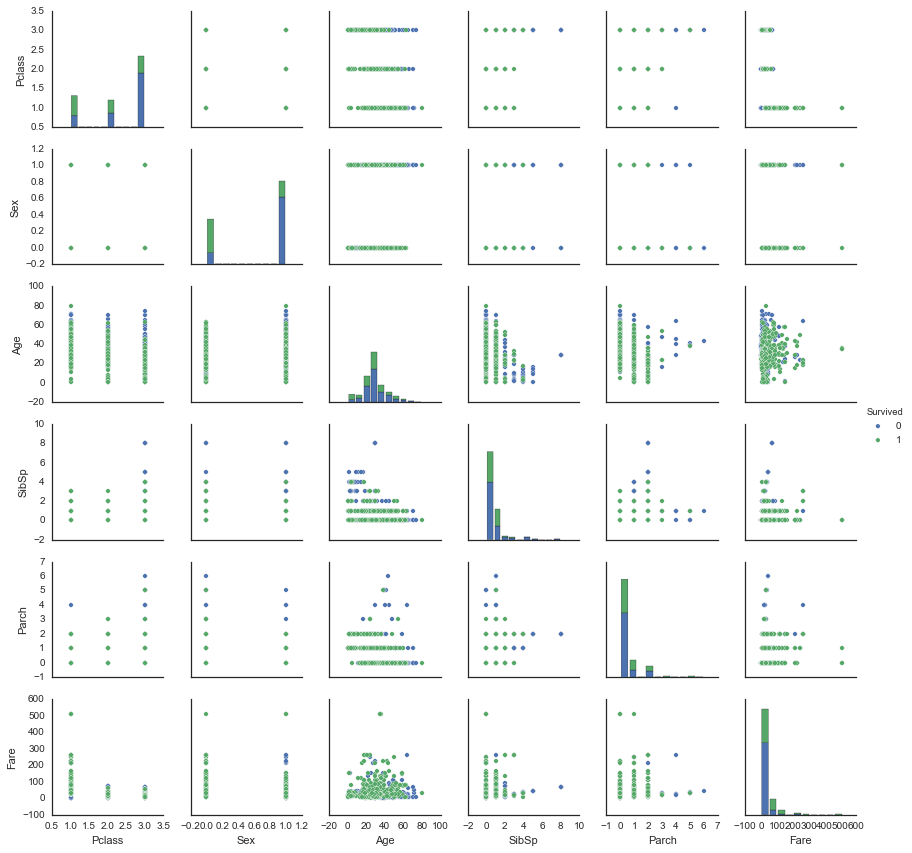

In [27]:
target   = "Survived"
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]
sb.pairplot(titanic[features + [target]], hue="Survived", size=2, vars=features)

In [28]:
target = "Survived"
non_features = ["Pclass", "Cabin", "PassengerId", "Name", "Ticket", "Embarked"]
# we drop PassengerId, Name, Ticket
titanic  = titanic.drop(non_features, axis=1)

In [29]:
titanic.columns.tolist()

['Survived',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked.C',
 'Embarked.Q',
 'Embarked.S',
 'Pclass.1',
 'Pclass.2',
 'Pclass.3',
 'Cabin.A',
 'Cabin.B',
 'Cabin.C',
 'Cabin.D',
 'Cabin.E',
 'Cabin.F',
 'Cabin.G',
 'Cabin.T',
 'Cabin.U']

### Sampling

/!\ take care /!\ Should we balance the number of Survivor or not???

**TOTRY**: drop positive data point (+1-%50, 0-%50)

In [30]:
print "There are Only %i %% of people survivors"%(len(titanic[titanic["Survived"] == 1])/ len(titanic)*100)
print "There are %i %% of people that not survived"%(len(titanic[titanic["Survived"] == 0]) / len(titanic)*100)

There are Only 38 % of people survivors
There are 61 % of people that not survived


In [31]:
print "Total number of data points: \t%i"%len(titanic)
print "Number of positiv output: \t%i"%(len(titanic[titanic["Survived"] == 1]))
print "Number of negetiv output: \t%i"%(len(titanic[titanic["Survived"] == 0]))

Total number of data points: 	891
Number of positiv output: 	342
Number of negetiv output: 	549


In [32]:
train_data, test_data = train_test_split(titanic, test_size=0.2, random_state=1)
print "Size of the total dataset: \t%i"%len(titanic)
print "Size of the training dataset: \t%i"%len(train_data)
print "Size of the test dataset:\t%i"%len(test_data)

Size of the total dataset: 	891
Size of the training dataset: 	712
Size of the test dataset:	179


In [33]:
train_data.head(10)

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked.C,Embarked.Q,Embarked.S,Pclass.1,...,Pclass.3,Cabin.A,Cabin.B,Cabin.C,Cabin.D,Cabin.E,Cabin.F,Cabin.G,Cabin.T,Cabin.U
301,1,1,29,2,0,23.2500,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
309,1,0,30,0,0,56.9292,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
516,1,0,34,0,0,10.5000,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
120,0,1,21,2,0,73.5000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
570,1,1,62,0,0,10.5000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
730,1,0,29,0,0,211.3375,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
228,0,1,18,0,0,13.0000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
563,0,1,29,0,0,8.0500,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
311,1,0,18,2,2,262.3750,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
613,0,1,29,0,0,7.7500,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1


### Build the model

In [27]:
response = test_data.copy()
forest = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=50, random_state=1)
forest.fit(train_data.drop(target, axis=1), train_data[target])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

### Make a predition

In [28]:
response["prediction"] = forest.predict(test_data.drop(target, axis=1)).astype(int)

In [29]:
# miss classified
test_miss = len(response[response["prediction"] !=  response[target]])
train_miss = np.abs(train_data[target] - forest.predict(train_data.drop(target, axis=1))).sum()

# classification score
train_score = forest.score(train_data.drop(target, axis=1), train_data[target])
test_score = forest.score(test_data.drop(target, axis=1), test_data[target])

print "< %i > Data Points miss classified => train score: %.3f%%"%(train_miss, train_score) 
print "< %i > Data Points miss classified => test  score: %.3f%%"%(test_miss, test_score) 
print ""
print "F1 Score from the test set", f1_score(response["prediction"], response[target])

< 99 > Data Points miss classified => train score: 0.861%
< 39 > Data Points miss classified => test  score: 0.782%

F1 Score from the test set 0.692913385827


### Assessing performances

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Survived", "Dead"])
    plt.yticks(tick_marks, ["Survived", "Dead"])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
tab = confusion_matrix(response[target], response["prediction"]) / len(response)
f = np.vectorize(lambda y:   math.floor(100 * y) / 100 , otypes=[np.float])
table = pd.DataFrame(f(tab)).rename(columns={0: "Guess Survived", 1: "Guess Dead"})
table = table.rename(index={0: "Realy Survived", 1: "Realy Dead"})
table.head()

,Guess Survived,Guess Dead
Realy Survived,0.53,0.05
Realy Dead,0.16,0.24


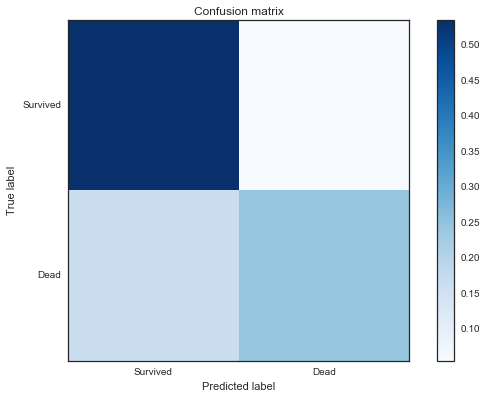

In [33]:
plot_confusion_matrix(tab)

### ------------------------- Tunning parameters -------------------------

#### Cross validate the n estimator

In [34]:
cross_vadlidation_set = StratifiedKFold(titanic[target].tolist(), 10, random_state=1)

In [53]:
verbose = False 
cross_train_error = []
cross_valid_error = []

estimators = 20
# ct -> cross_train
# cv -> cross_valid

iterration = 0
cv_iterration = 0

for estimators in range(800,1000,20):
    if(verbose): print "========= Running Cross Validation on estimators: ",estimators
    cv_iterration = train_score = valid_score = 0
    iterration = iterration + 1
    
    for ct, cv in cross_vadlidation_set:
        cv_iterration = cv_iterration + 1

    
        if(verbose): print "::::::::: Running Cross Validation on estimators," + \
        "%i used value: %i :::::::::"%(cv_iterration, estimators)
    
        cross_train_set = titanic[titanic.index.isin(ct)]
        cross_valid_set = titanic[titanic.index.isin(cv)]
    
        cross_forest = RandomForestClassifier(n_estimators=estimators,
                                              max_depth=10,
                                              min_samples_split=50,
                                              random_state=1)
    
        cross_forest.fit(cross_train_set.drop(target, axis=1), cross_train_set[target])
    
        train_score = train_score + cross_forest.score(
            cross_train_set.drop(target, axis=1), 
            cross_train_set[target])
        
        valid_score = valid_score + cross_forest.score(
            cross_valid_set.drop(target, axis=1), 
            cross_valid_set[target])
    
    
    train_error = 1 - (train_score / 10)
    test_error = 1 - (valid_score / 10)
    
    print "Iterration n° %i => Estimator: %i Sum of errors"%(cv_iterration, estimators) + \
    " train(%.3f) , valid(%.3f) "%(train_error, test_error)
    cross_train_error.append(train_error)#/cross_vadlidation_set.n_folds)
    cross_valid_error.append(test_error)#/cross_vadlidation_set.n_folds)

minerr = min(cross_valid_error)
minerr_idx = cross_valid_error.index(minerr)
print "========= End of the Crossvalidation over estimators"
print "========= The minimum vaidation error: (idx: %i, err: %.3f)"%(minerr_idx, minerr)

Iterration n° 10 => Estimator: 800 Sum of errors train(0.152) , valid(0.182) 
Iterration n° 10 => Estimator: 820 Sum of errors train(0.151) , valid(0.182) 
Iterration n° 10 => Estimator: 840 Sum of errors train(0.152) , valid(0.183) 
Iterration n° 10 => Estimator: 860 Sum of errors train(0.152) , valid(0.183) 
Iterration n° 10 => Estimator: 880 Sum of errors train(0.151) , valid(0.182) 
Iterration n° 10 => Estimator: 900 Sum of errors train(0.151) , valid(0.179) 
Iterration n° 10 => Estimator: 920 Sum of errors train(0.151) , valid(0.183) 
Iterration n° 10 => Estimator: 940 Sum of errors train(0.151) , valid(0.182) 
Iterration n° 10 => Estimator: 960 Sum of errors train(0.151) , valid(0.182) 
Iterration n° 10 => Estimator: 980 Sum of errors train(0.151) , valid(0.182) 
========= End of the Crossvalidation over estimators
========= The minimum vaidation error: (idx: 5, err: 0.179)


In [45]:
#df[df.index.map(lambda x: x[0] in stk_list)]

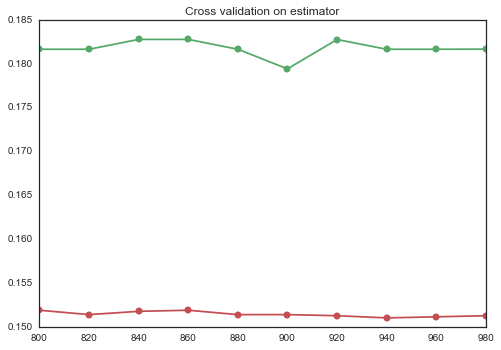

In [54]:
plt.figure()
plt.title("Cross validation on estimator")
plt.plot(range(800,1000,20), cross_train_error, 'o-', color="r", label="Training error")
plt.plot(range(800,1000,20), cross_valid_error, 'o-', color="g", label="Cross-validation error")

In [56]:
verbose = False 
cross_train_error = []
cross_valid_error = []

estimators = 20
# ct -> cross_train
# cv -> cross_valid

iterration = 0
cv_iterration = 0

for depth in range(3,15,1):
    if(verbose): print "========= Running Cross Validation on max_depth: ",estimators
    cv_iterration = train_score = valid_score = 0
    iterration = iterration + 1
    
    for ct, cv in cross_vadlidation_set:
        cv_iterration = cv_iterration + 1

    
        if(verbose): print "::::::::: Running Cross Validation on estimators," + \
        "%i used value: %i :::::::::"%(cv_iterration, estimators)
    
        cross_train_set = titanic[titanic.index.isin(ct)]
        cross_valid_set = titanic[titanic.index.isin(cv)]
    
        cross_forest = RandomForestClassifier(n_estimators=900,
                                              max_depth=depth,
                                              min_samples_split=50,
                                              random_state=1)
    
        cross_forest.fit(cross_train_set.drop(target, axis=1), cross_train_set[target])
    
        train_score = train_score + cross_forest.score(
            cross_train_set.drop(target, axis=1), 
            cross_train_set[target])
        
        valid_score = valid_score + cross_forest.score(
            cross_valid_set.drop(target, axis=1), 
            cross_valid_set[target])
    
    
    train_error = 1 - (train_score / 10)
    test_error = 1 - (valid_score / 10)
    
    print "Iterration n° %i => Depth: %i Sum of errors"%(iterration, depth) + \
    " train(%.3f) , valid(%.3f) "%(train_error, test_error)
    cross_train_error.append(train_error)#/cross_vadlidation_set.n_folds)
    cross_valid_error.append(test_error)#/cross_vadlidation_set.n_folds)
    
minerr = min(cross_valid_error)
minerr_idx = cross_valid_error.index(minerr)
print "========= End of the Crossvalidation over Depth"
print "========= The minimum vaidation error: (idx: %i, err: %.6f)"%(minerr_idx, minerr)

Iterration n° 10 => Depth: 3 Sum of errors train(0.193) , valid(0.209) 
Iterration n° 10 => Depth: 4 Sum of errors train(0.171) , valid(0.201) 
Iterration n° 10 => Depth: 5 Sum of errors train(0.161) , valid(0.187) 
Iterration n° 10 => Depth: 6 Sum of errors train(0.157) , valid(0.184) 
Iterration n° 10 => Depth: 7 Sum of errors train(0.156) , valid(0.183) 
Iterration n° 10 => Depth: 8 Sum of errors train(0.155) , valid(0.181) 
Iterration n° 10 => Depth: 9 Sum of errors train(0.153) , valid(0.181) 
Iterration n° 10 => Depth: 10 Sum of errors train(0.151) , valid(0.179) 
Iterration n° 10 => Depth: 11 Sum of errors train(0.150) , valid(0.182) 
Iterration n° 10 => Depth: 12 Sum of errors train(0.150) , valid(0.182) 
Iterration n° 10 => Depth: 13 Sum of errors train(0.149) , valid(0.183) 
Iterration n° 10 => Depth: 14 Sum of errors train(0.149) , valid(0.182) 
========= End of the Crossvalidation over Depth
========= The minimum vaidation error: (idx: 7, err: 0.179417)


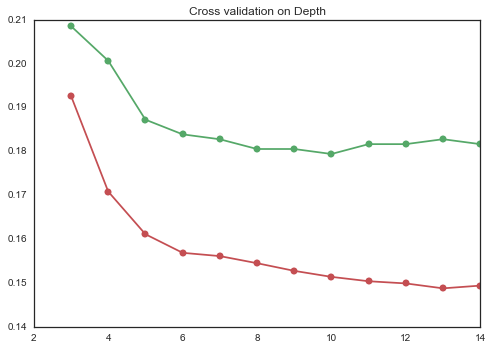

In [58]:
plt.figure()
plt.title("Cross validation on Depth")
plt.plot(range(3,15,1), cross_train_error, 'o-', color="r", label="Training error")
plt.plot(range(3,15,1), cross_valid_error, 'o-', color="g", label="Cross-validation error")

In [61]:
verbose = False 
cross_train_error = []
cross_valid_error = []

estimators = 20
# ct -> cross_train
# cv -> cross_valid

iterration = 0
cv_iterration = 0

for min_split in range(10,300,10):
    if(verbose): print "========= Running Cross Validation on max_depth: ",estimators
    cv_iterration = train_score = valid_score = 0
    iterration = iterration + 1
    
    for ct, cv in cross_vadlidation_set:
        cv_iterration = cv_iterration + 1

    
        if(verbose): print "::::::::: Running Cross Validation on estimators," + \
        "%i used value: %i :::::::::"%(cv_iterration, estimators)
    
        cross_train_set = titanic[titanic.index.isin(ct)]
        cross_valid_set = titanic[titanic.index.isin(cv)]
    
        cross_forest = RandomForestClassifier(n_estimators=900,
                                              max_depth=10,
                                              min_samples_split=min_split,
                                              random_state=1)
    
        cross_forest.fit(cross_train_set.drop(target, axis=1), cross_train_set[target])
    
        train_score = train_score + cross_forest.score(
            cross_train_set.drop(target, axis=1), 
            cross_train_set[target])
        
        valid_score = valid_score + cross_forest.score(
            cross_valid_set.drop(target, axis=1), 
            cross_valid_set[target])
    
    
    train_error = 1 - (train_score / 10)
    test_error = 1 - (valid_score / 10)
    
    print "Iterration n° %i => Min Split: %i Sum of errors"%(iterration, min_split) + \
    " train(%.3f) , valid(%.3f) "%(train_error, test_error)
    cross_train_error.append(train_error)#/cross_vadlidation_set.n_folds)
    cross_valid_error.append(test_error)#/cross_vadlidation_set.n_folds)
    
minerr = min(cross_valid_error)
minerr_idx = cross_valid_error.index(minerr)
print "========= End of the Crossvalidation over Depth"
print "========= The minimum vaidation error: (idx: %i, err: %.6f)"%(minerr_idx, minerr)

Iterration n° 1 => Depth: 14 Sum of errors train(0.101) , valid(0.174) 
Iterration n° 2 => Depth: 14 Sum of errors train(0.128) , valid(0.174) 
Iterration n° 3 => Depth: 14 Sum of errors train(0.139) , valid(0.176) 
Iterration n° 4 => Depth: 14 Sum of errors train(0.145) , valid(0.176) 
Iterration n° 5 => Depth: 14 Sum of errors train(0.151) , valid(0.179) 
Iterration n° 6 => Depth: 14 Sum of errors train(0.158) , valid(0.182) 
Iterration n° 7 => Depth: 14 Sum of errors train(0.163) , valid(0.188) 
Iterration n° 8 => Depth: 14 Sum of errors train(0.167) , valid(0.196) 
Iterration n° 9 => Depth: 14 Sum of errors train(0.174) , valid(0.204) 
Iterration n° 10 => Depth: 14 Sum of errors train(0.179) , valid(0.205) 
Iterration n° 11 => Depth: 14 Sum of errors train(0.178) , valid(0.204) 
Iterration n° 12 => Depth: 14 Sum of errors train(0.178) , valid(0.211) 
Iterration n° 13 => Depth: 14 Sum of errors train(0.181) , valid(0.216) 
Iterration n° 14 => Depth: 14 Sum of errors train(0.182) , v

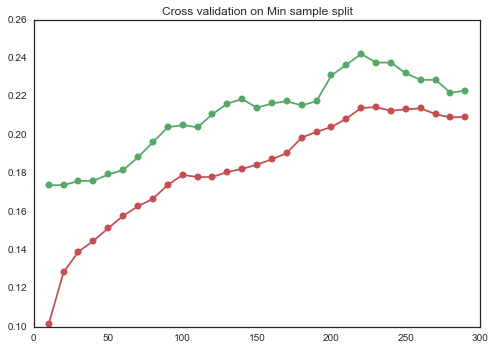

In [63]:
plt.figure()
plt.title("Cross validation on Min sample split")
plt.plot(range(10,300,10), cross_train_error, 'o-', color="r", label="Training error")
plt.plot(range(10,300,10), cross_valid_error, 'o-', color="g", label="Cross-validation error")